In [1]:
%load_ext autoreload
#%load_ext nb_black
%load_ext autotime
%autoreload 2


from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import warnings
import logging
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 200

random.seed(42)
np.random.seed(42)

logging.basicConfig(level=logging.INFO)

time: 754 ms (started: 2024-06-11 17:20:18 -07:00)


In [2]:
df = pd.read_csv("raw_pivoted.csv.gz", compression="gzip", index_col=0)
df

,degraded,failed,success
timestamp,,,
2024-03-17 23:14,NaN,NaN,1.0
2024-03-17 23:55,NaN,NaN,1.0
2024-03-17 23:57,NaN,NaN,1.0
2024-03-17 23:58,NaN,NaN,3.0
2024-03-17 23:59,1.0,NaN,58.0
...,...,...,...
2024-03-30 23:54,4.0,NaN,48.0
2024-03-30 23:55,2.0,NaN,44.0
2024-03-30 23:56,NaN,NaN,32.0


time: 20.8 ms (started: 2024-06-11 17:20:20 -07:00)


In [3]:
df = df.fillna(0)
# df["degraded"] = df[["failed"]]
# df.plot(subplots=True)

time: 598 µs (started: 2024-06-11 17:20:21 -07:00)


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

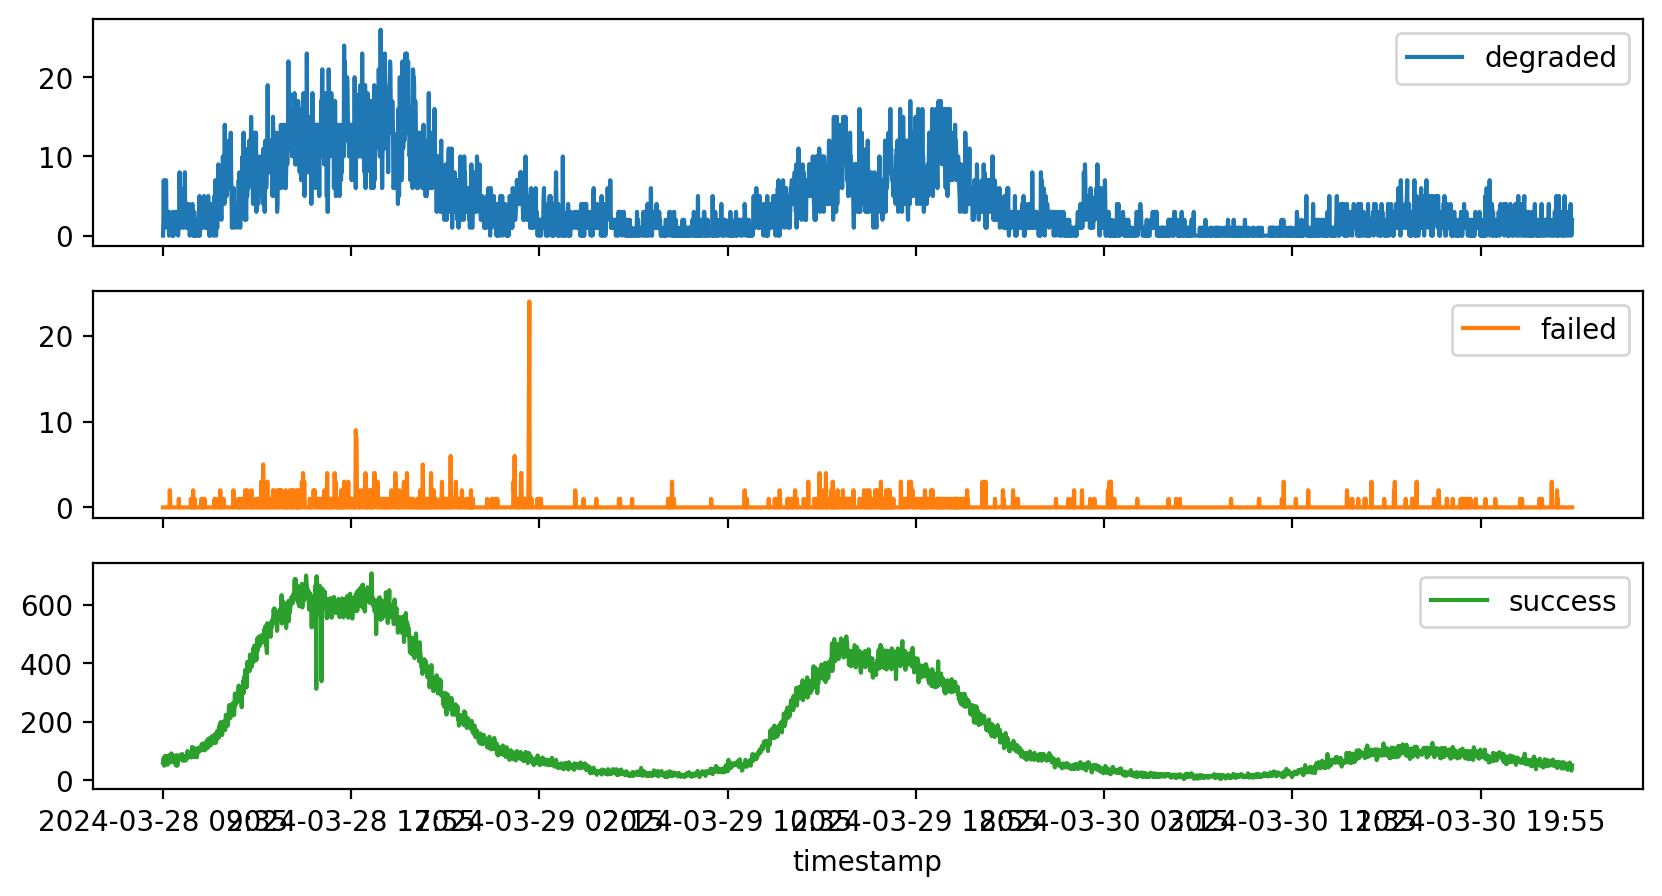

time: 322 ms (started: 2024-06-11 17:20:22 -07:00)


In [4]:
TEST_SPLIT_RATIO = 0.2
df_train, df_test = df.iloc[:-int(TEST_SPLIT_RATIO * (len(df)))], df.iloc[-int(TEST_SPLIT_RATIO * (len(df))):]
df_test.plot(subplots=True)

In [5]:
from numalogic.transforms import LogTransformer

tx = LogTransformer()
x_train = tx.fit_transform(df_train.to_numpy())
x_test = tx.transform(df_test.to_numpy())

time: 2.64 s (started: 2024-06-11 17:20:24 -07:00)


In [6]:
from torch.utils.data import DataLoader
from numalogic.tools.data import StreamingDataset
from numalogic.models.autoencoder import TimeseriesTrainer
from numalogic.models.autoencoder.variants import VanillaAE

train_ds = StreamingDataset(x_train, seq_len=10)
test_ds = StreamingDataset(x_test, seq_len=10)

INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1


time: 14.9 ms (started: 2024-06-11 17:20:29 -07:00)


In [7]:
from numalogic.models.autoencoder.variants.vanilla import MultichannelAE

model_3 = MultichannelAE(seq_len=10, n_channels=3)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_3, train_dataloaders=DataLoader(train_ds, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=1.8689
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.7794
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.3698
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.3312
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.2980
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.2658
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.2371
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.2154
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.1960
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1821
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1686
INFO:pytorch_lightning.utilit

time: 7.22 s (started: 2024-06-11 17:20:33 -07:00)


[0.04239093 0.01024601 0.05530078] [0.02259875 0.02195675 0.04508378]


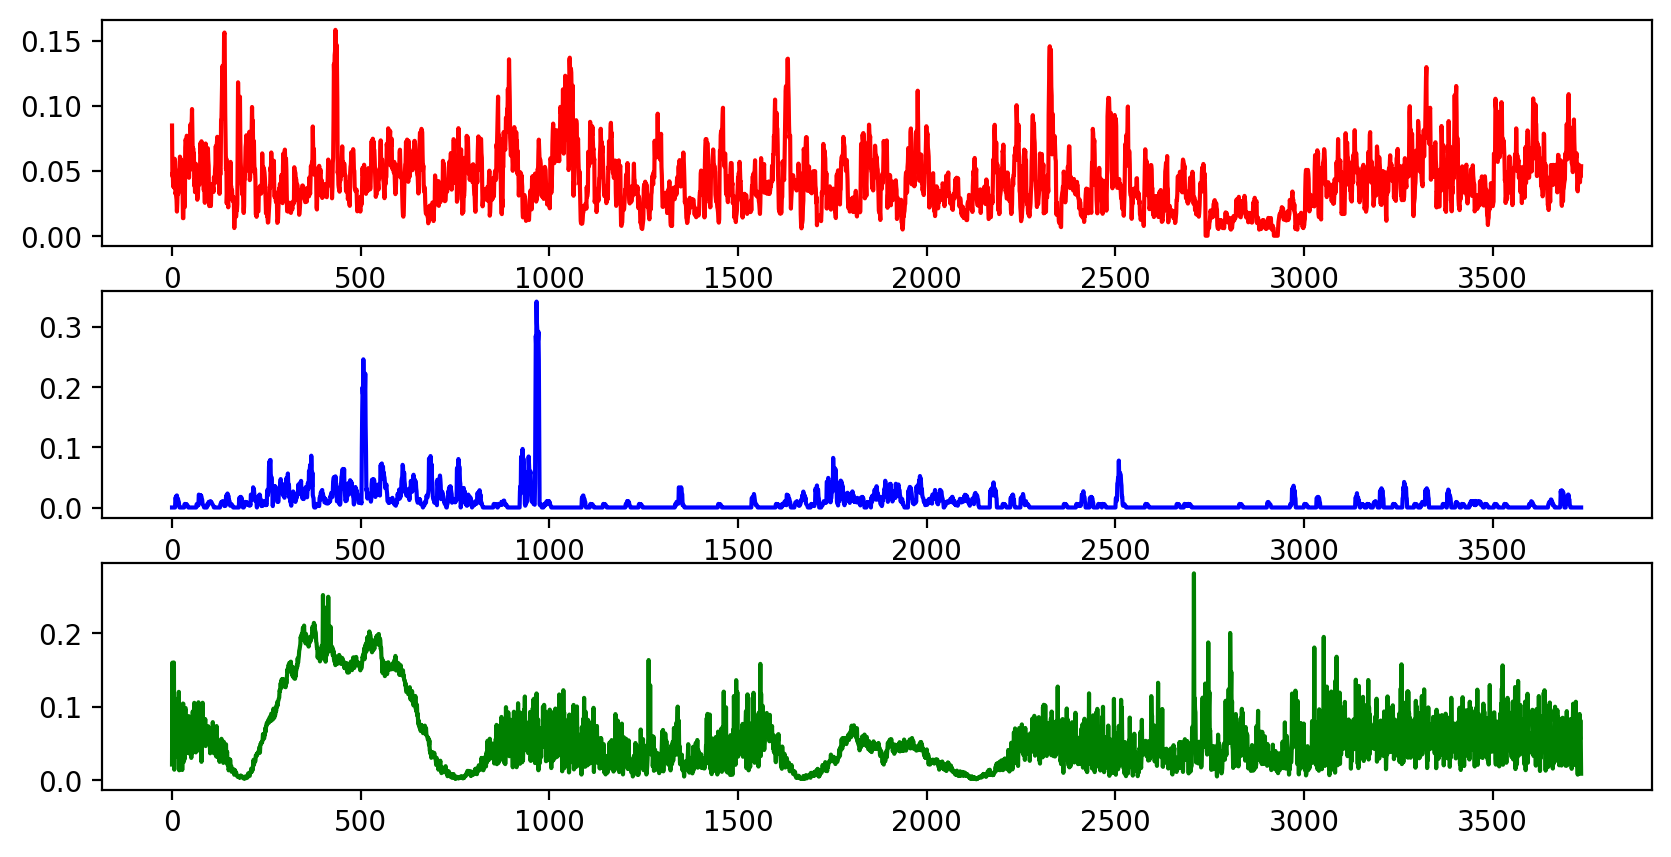

time: 340 ms (started: 2024-06-11 17:20:41 -07:00)


In [8]:
import torch

test_reconerr = trainer.predict(model_3, dataloaders=DataLoader(test_ds, batch_size=512), unbatch=False)
test_reconerr = torch.mean(test_reconerr, dim=1).detach().numpy()
_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr[:, 0], color="red")
ax[1].plot(test_reconerr[:, 1], color="blue")
ax[2].plot(test_reconerr[:, 2], color="green")
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

In [9]:
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

[0.04239093 0.01024601 0.05530078] [0.02259875 0.02195675 0.04508378]
time: 2.02 ms (started: 2024-06-11 17:20:44 -07:00)


# Testing Multichannel Linear Layer

In [10]:
from numalogic.models.autoencoder.variants import VanillaICAE

model_mc = VanillaICAE(seq_len=10, n_features=3)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_mc, train_dataloaders=DataLoader(train_ds, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=1.8933
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.6465
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.2971
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.2721
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.2678
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.2648
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.2561
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.2357
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.2077
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1761
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1502
INFO:pytorch_lightning.utilit

time: 4.17 s (started: 2024-06-11 17:22:01 -07:00)


In [11]:
VanillaAE(seq_len=10)

VanillaAE(
  (encoder): _VanillaEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=10, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (decoder): _Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=16, out_features=10, bias=True)
    )
  )
)

time: 2.58 ms (started: 2024-06-11 17:22:07 -07:00)


In [12]:
model_mc

VanillaICAE(
  (encoder): _VanillaEncoder(
    (encoder): Sequential(
      (0): MultiChannelLinear(in_features=10, out_features=16, n_channels=3)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): MultiChannelLinear(in_features=16, out_features=8, n_channels=3)
      (4): Tanh()
      (5): Dropout(p=0.25, inplace=False)
    )
  )
  (decoder): _Decoder(
    (decoder): Sequential(
      (0): MultiChannelLinear(in_features=8, out_features=16, n_channels=3)
      (1): Tanh()
      (2): Dropout(p=0.25, inplace=False)
      (3): MultiChannelLinear(in_features=16, out_features=10, n_channels=3)
    )
  )
)

time: 1.4 ms (started: 2024-06-11 17:22:11 -07:00)


In [13]:
test_reconerr = trainer.predict(model_mc, dataloaders=DataLoader(test_ds, batch_size=512), unbatch=False)
test_reconerr = torch.mean(test_reconerr, dim=1).detach().numpy()
test_reconerr.shape

(3735, 3)

time: 17.1 ms (started: 2024-06-11 17:22:16 -07:00)


[0.04808131 0.01493764 0.08386309] [0.02590389 0.02881919 0.09772316]


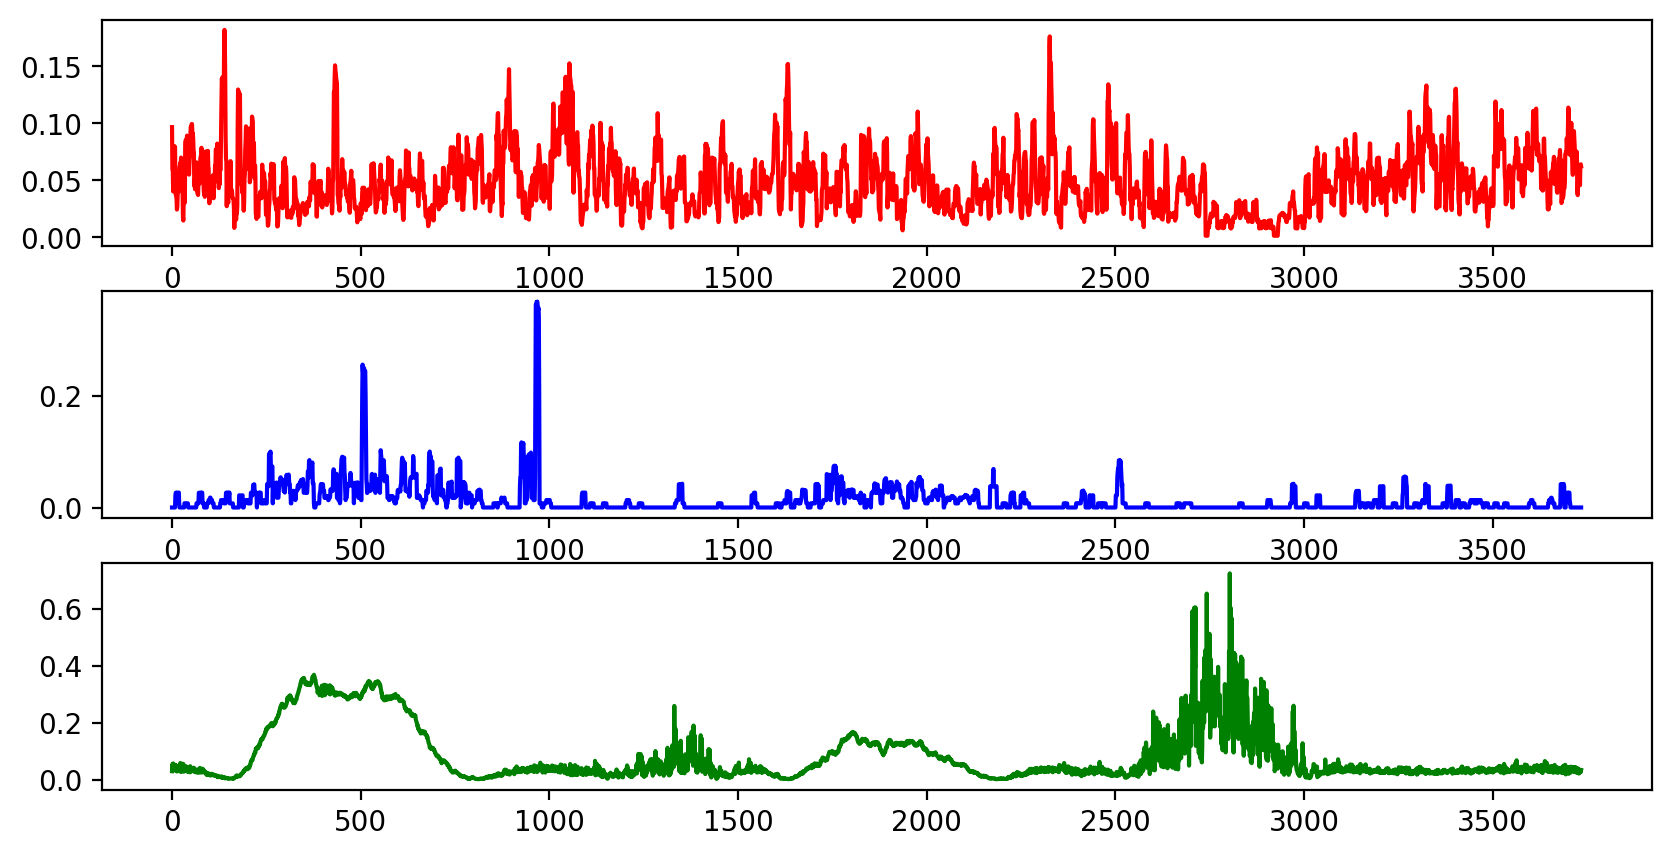

time: 222 ms (started: 2024-06-11 17:22:17 -07:00)


In [14]:
_, ax = plt.subplots(3, 1)
ax[0].plot(test_reconerr[:, 0], color="red")
ax[1].plot(test_reconerr[:, 1], color="blue")
ax[2].plot(test_reconerr[:, 2], color="green")
print(np.mean(test_reconerr, axis=0), np.std(test_reconerr, axis=0))

In [15]:
df_test

,degraded,failed,success
timestamp,,,
2024-03-28 09:35,0.0,0.0,59.0
2024-03-28 09:36,2.0,0.0,70.0
2024-03-28 09:37,7.0,0.0,76.0
2024-03-28 09:38,2.0,0.0,49.0
2024-03-28 09:39,1.0,0.0,63.0
...,...,...,...
2024-03-30 23:54,4.0,0.0,48.0
2024-03-30 23:55,2.0,0.0,44.0
2024-03-30 23:56,0.0,0.0,32.0


time: 13.6 ms (started: 2024-06-11 17:22:21 -07:00)


In [16]:
train_ds_fd = StreamingDataset(x_train[:, [1, 0]], seq_len=10)
test_ds_fd = StreamingDataset(x_test[:, [1, 0]], seq_len=10)
train_ds_fs = StreamingDataset(x_train[:, [1, 2]], seq_len=10)
test_ds_fs = StreamingDataset(x_test[:, [1, 2]], seq_len=10)

INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1
INFO:numalogic.tools.data:StreamingDataset initialized with seq_len: 10, stride: 1


time: 2.38 ms (started: 2024-06-11 17:22:24 -07:00)


In [17]:
model_mc_fd = VanillaICAE(seq_len=10, n_features=2)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_mc_fd, train_dataloaders=DataLoader(train_ds_fd, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=0.7002
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.1573
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.1023
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.0676
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.0626
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.0595
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.0568
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.0552
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.0543
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.0520
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.0515
INFO:pytorch_lightning.utilit

time: 4.26 s (started: 2024-06-11 17:22:29 -07:00)


In [18]:
model_3_fd = MultichannelAE(seq_len=10, n_channels=2)
trainer = TimeseriesTrainer(max_epochs=50, accelerator="cpu", deterministic=True)
trainer.fit(model_3_fd, train_dataloaders=DataLoader(train_ds_fd, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=0.7619
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.2439
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.1542
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.1093
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.0922
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.0811
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.0731
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.0682
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.0634
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.0610
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.0578
INFO:pytorch_lightning.utilit

time: 5.24 s (started: 2024-06-11 17:22:34 -07:00)


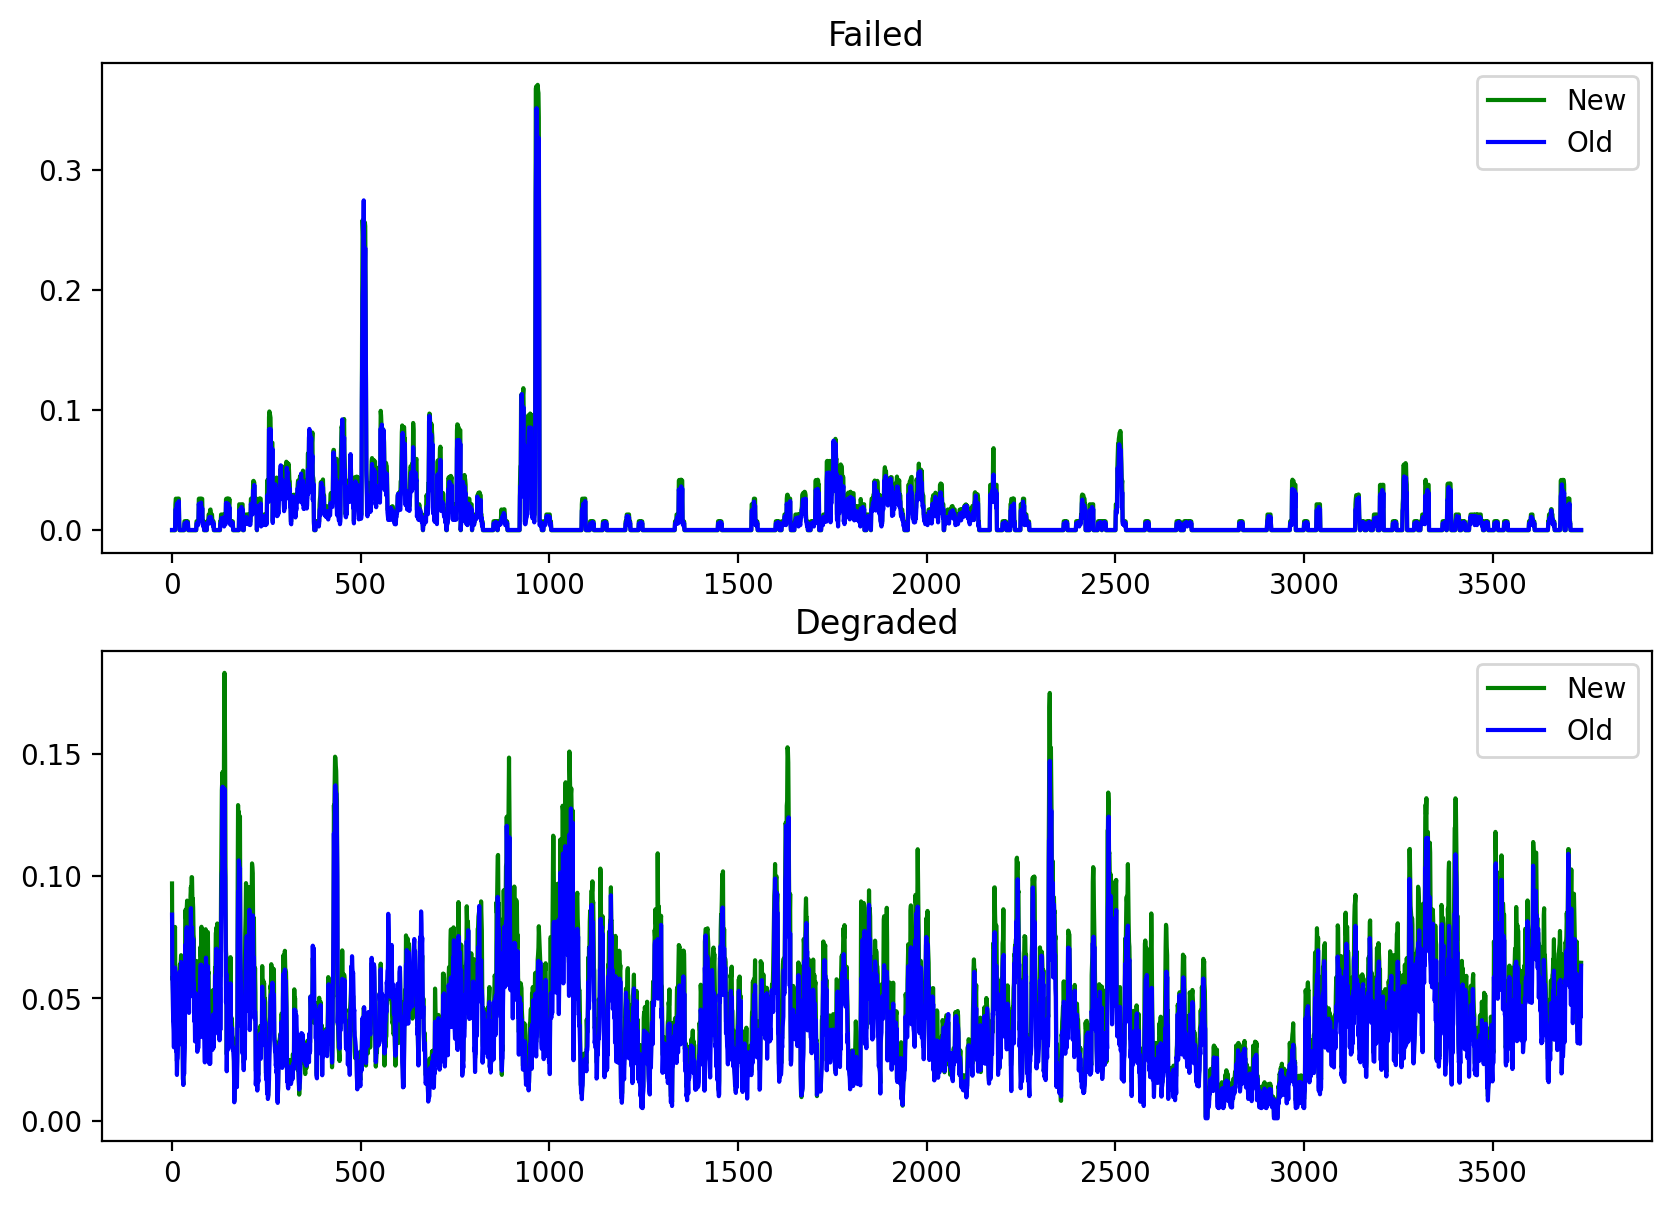

time: 343 ms (started: 2024-06-11 17:22:41 -07:00)


In [19]:
test_reconerr_mc = trainer.predict(model_mc_fd, dataloaders=DataLoader(test_ds_fd, batch_size=512), unbatch=False)
test_reconerr_mc = torch.mean(test_reconerr_mc, dim=1).detach().numpy()

test_reconerr_3 = trainer.predict(model_3_fd, dataloaders=DataLoader(test_ds_fd, batch_size=512), unbatch=False)
test_reconerr_3 = torch.mean(test_reconerr_3, dim=1).detach().numpy()

_, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(test_reconerr_mc[:, 0], color="green", label="New")
ax[0].plot(test_reconerr_3[:, 0], color="blue", label="Old")
ax[0].set_title("Failed")
ax[1].plot(test_reconerr_mc[:, 1], color="green", label="New")
ax[1].plot(test_reconerr_3[:, 1], color="blue", label="Old")
ax[1].set_title("Degraded")
ax[0].legend()
ax[1].legend()

In [20]:
model_mc_fs = VanillaICAE(seq_len=10, n_features=2)
trainer = TimeseriesTrainer(max_epochs=70, accelerator="cpu", deterministic=True)
trainer.fit(model_mc_fs, train_dataloaders=DataLoader(train_ds_fs, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=2.2409
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.7678
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.3602
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.3536
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.3498
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.3432
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.3326
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.3051
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.2544
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.1927
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1762
INFO:numalogic.tools.callback

time: 5.69 s (started: 2024-06-11 17:22:49 -07:00)


In [21]:
model_3_fs = MultichannelAE(seq_len=10, n_channels=2)
trainer = TimeseriesTrainer(max_epochs=70, accelerator="cpu", deterministic=True)
trainer.fit(model_3_fs, train_dataloaders=DataLoader(train_ds_fs, batch_size=512))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:numalogic.tools.callbacks:epoch=1, train_loss=2.1450
INFO:numalogic.tools.callbacks:epoch=5, train_loss=0.9841
INFO:numalogic.tools.callbacks:epoch=10, train_loss=0.4292
INFO:numalogic.tools.callbacks:epoch=15, train_loss=0.3866
INFO:numalogic.tools.callbacks:epoch=20, train_loss=0.3390
INFO:numalogic.tools.callbacks:epoch=25, train_loss=0.2960
INFO:numalogic.tools.callbacks:epoch=30, train_loss=0.2711
INFO:numalogic.tools.callbacks:epoch=35, train_loss=0.2478
INFO:numalogic.tools.callbacks:epoch=40, train_loss=0.2356
INFO:numalogic.tools.callbacks:epoch=45, train_loss=0.2120
INFO:numalogic.tools.callbacks:epoch=50, train_loss=0.1993
INFO:numalogic.tools.callback

time: 7.07 s (started: 2024-06-11 17:22:55 -07:00)


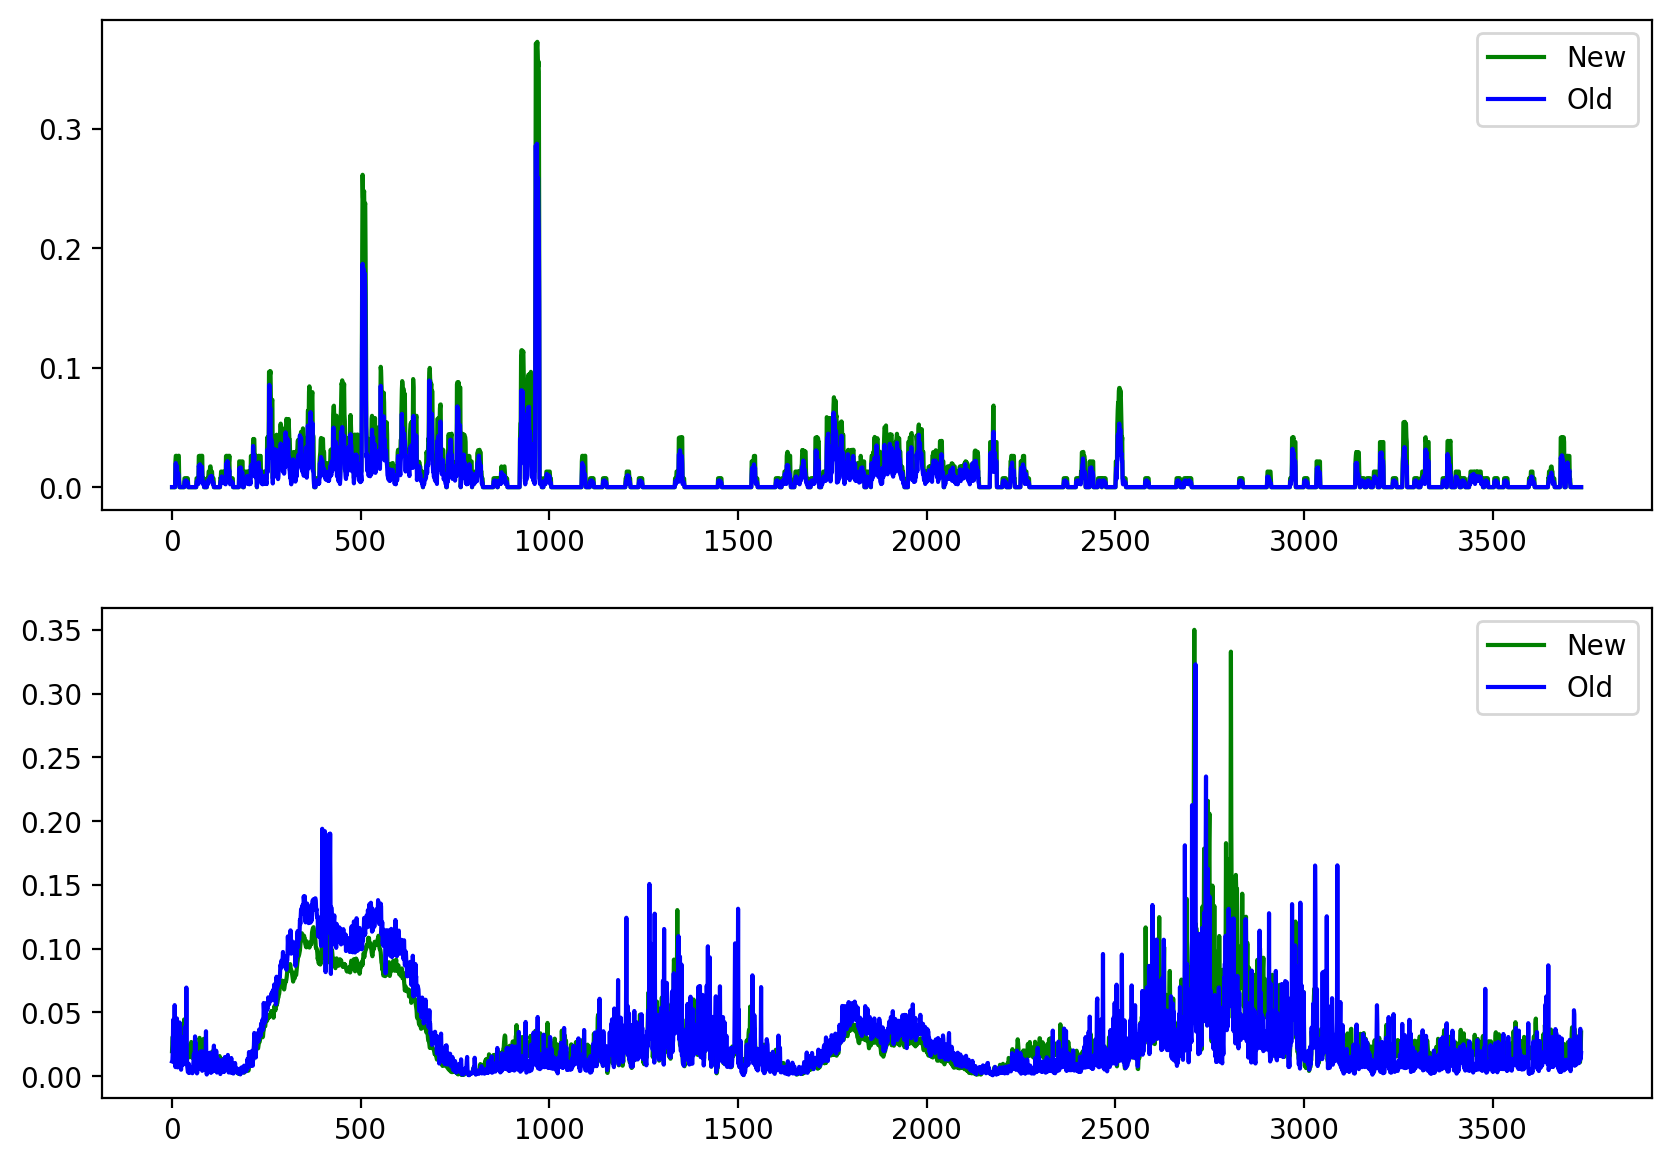

time: 302 ms (started: 2024-06-11 17:23:04 -07:00)


In [22]:
test_reconerr_mc = trainer.predict(model_mc_fs, dataloaders=DataLoader(test_ds_fs, batch_size=512), unbatch=False)
test_reconerr_mc = torch.mean(test_reconerr_mc, dim=1).detach().numpy()

test_reconerr_3 = trainer.predict(model_3_fs, dataloaders=DataLoader(test_ds_fs, batch_size=512), unbatch=False)
test_reconerr_3 = torch.mean(test_reconerr_3, dim=1).detach().numpy()

_, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(test_reconerr_mc[:, 0], color="green", label="New")
ax[0].plot(test_reconerr_3[:, 0], color="blue", label="Old")
ax[1].plot(test_reconerr_mc[:, 1], color="green", label="New")
ax[1].plot(test_reconerr_3[:, 1], color="blue", label="Old")
ax[0].legend()
ax[1].legend()